In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from scipy import stats
import json
import tensorflow as tf
import folium



1. loading the data file in csv

In [40]:
df = pd.read_csv('../../data/raw/binary_mannual_collection/sensor_data huda.csv')
df.head()

,Unnamed: 0,timestamp,ax,ay,az,wx,wy,wz,latitude,longitude,speed,roadQuality
0,0,1763092679400,0.238278,0.975367,9.909944,-0.011802,-0.004545,0.004843,28.405865,76.942729,16.06,1
1,1,1763092679500,0.233199,0.963102,9.464037,-0.033919,-0.001485,0.005055,28.405865,76.942729,16.06,1
2,2,1763092679602,0.207032,0.918832,9.267086,-0.051518,-0.001817,0.005808,28.405963,76.942892,16.56,1
3,3,1763092679701,0.221641,0.967714,9.293359,-0.030533,0.001912,0.005941,28.405963,76.942892,16.56,1
4,4,1763092679803,0.181457,1.045507,10.001403,0.002224,-0.001840,0.004344,28.405963,76.942892,16.56,1


2. creating windows of size 20, without any overlapping

In [ ]:
def create_windows(df, window_size=20, step_size=20):
    """
    Converts a dataframe into windows for the Hybrid Model (NO LABELS).
    
    Returns:
        X_raw:  (N, 20, 7)
        X_stats: (N, 42)
    """

    feature_cols = [
        'ax', 'ay', 'az',
        'wx', 'wy', 'wz',
        'speed'
    ]

    X_raw_list = []
    X_stats_list = []

    for i in range(0, len(df) - window_size + 1, step_size):
        
        window = df.iloc[i : i + window_size]

        # --- RAW DATA ---
        raw_data = window[feature_cols].values
        X_raw_list.append(raw_data)

        # --- STAT FEATURES ---
        stats_row = []

        for col in feature_cols:
            series = window[col].values

            stats_row.append(np.mean(series))
            stats_row.append(np.std(series))
            stats_row.append(np.sqrt(np.mean(series**2)))
            stats_row.append(np.max(series) - np.min(series))

            with warnings.catch_warnings():
                warnings.simplefilter("ignore", RuntimeWarning)
                stats_row.append(stats.skew(series, bias=False))
                stats_row.append(stats.kurtosis(series, fisher=True, bias=False))

        X_stats_list.append(stats_row)

    X_raw = np.array(X_raw_list)
    X_stats = np.array(X_stats_list)

    return X_raw, X_stats

test = df.dropna()

X_raw, X_stats = create_windows(test, window_size=20, step_size=20)

print("-"*30)
print(f"Original Rows: {len(test)}")
print(f"Generated Windows: {len(X_raw)}")
print("-" * 30)
print(f"X_raw Shape:   {X_raw.shape}")   # (N, 20, 7)
print(f"X_stats Shape: {X_stats.shape}") # (N, 42)


------------------------------
Original Rows: 2945
Generated Windows: 147
------------------------------
X_raw Shape:   (147, 20, 7)
X_stats Shape: (147, 42)


3. fixing NaNs (created from skewness and kurtosis) & scaling the data using the saved parameters

In [42]:
#fixing NaNs
X_raw = np.nan_to_num(X_raw)
X_stats = np.nan_to_num(X_stats)
# -----------------------------------------
# Load saved scaler parameters
# -----------------------------------------
with open("../model/scaler_params.json", "r") as f:
    scaler_params = json.load(f)

raw_mean = np.array(scaler_params["raw_scaler"]["mean"])
raw_std  = np.array(scaler_params["raw_scaler"]["std"])

stats_mean = np.array(scaler_params["stats_scaler"]["mean"])
stats_std  = np.array(scaler_params["stats_scaler"]["std"])

# -----------------------------------------
# Scale RAW window data in place
# -----------------------------------------
N, T, F = X_raw.shape
X_raw_reshaped = X_raw.reshape(-1, F)

X_raw_reshaped[:] = (X_raw_reshaped - raw_mean) / raw_std
X_raw[:] = X_raw_reshaped.reshape(N, T, F)

# -----------------------------------------
# Scale STATISTICAL features in place
# -----------------------------------------
X_stats[:] = (X_stats - stats_mean) / stats_std

print("Scaling applied using saved parameters.")


Scaling applied using saved parameters.


4. predicting

In [43]:
# --------------------------------------------------
# Load TFLite model
# --------------------------------------------------
interpreter = tf.lite.Interpreter(model_path="../model/model.tflite")
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Sanity print (run once)
print("Input details:", input_details)
print("Output details:", output_details)

# --------------------------------------------------
# Ensure correct dtype
# --------------------------------------------------
X_raw = X_raw.astype(np.float32)     # (N, 20, 7)
X_stats = X_stats.astype(np.float32) # (N, 42)

# --------------------------------------------------
# Predict
# --------------------------------------------------
predictions = []

for i in range(len(X_raw)):

    raw_input = X_raw[i:i+1]      # (1, 20, 7)
    stats_input = X_stats[i:i+1]  # (1, 42)

    # IMPORTANT: order matches training -> [raw, stats]
    interpreter.set_tensor(input_details[0]['index'], stats_input)
    interpreter.set_tensor(input_details[1]['index'], raw_input)

    interpreter.invoke()

    output = interpreter.get_tensor(output_details[0]['index'])
    predictions.append(output[0])

predictions = np.array(predictions)

# --------------------------------------------------
# Convert softmax to class label
# --------------------------------------------------
roadQuality = np.argmax(predictions, axis=1)

print("Predicted roadQuality:\n", roadQuality)


Input details: [{'name': 'serving_default_stat_features_input:0', 'index': 0, 'shape': array([ 1, 42]), 'shape_signature': array([-1, 42]), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}, {'name': 'serving_default_raw_sensor_input:0', 'index': 1, 'shape': array([ 1, 20,  7]), 'shape_signature': array([-1, 20,  7]), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
Output details: [{'name': 'StatefulPartitionedCall:0', 'index': 47, 'shape': array([1, 4]), 'shape_signature': array([-1,  4]), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'qua

5. plotting the raw sensor readings by predictions 

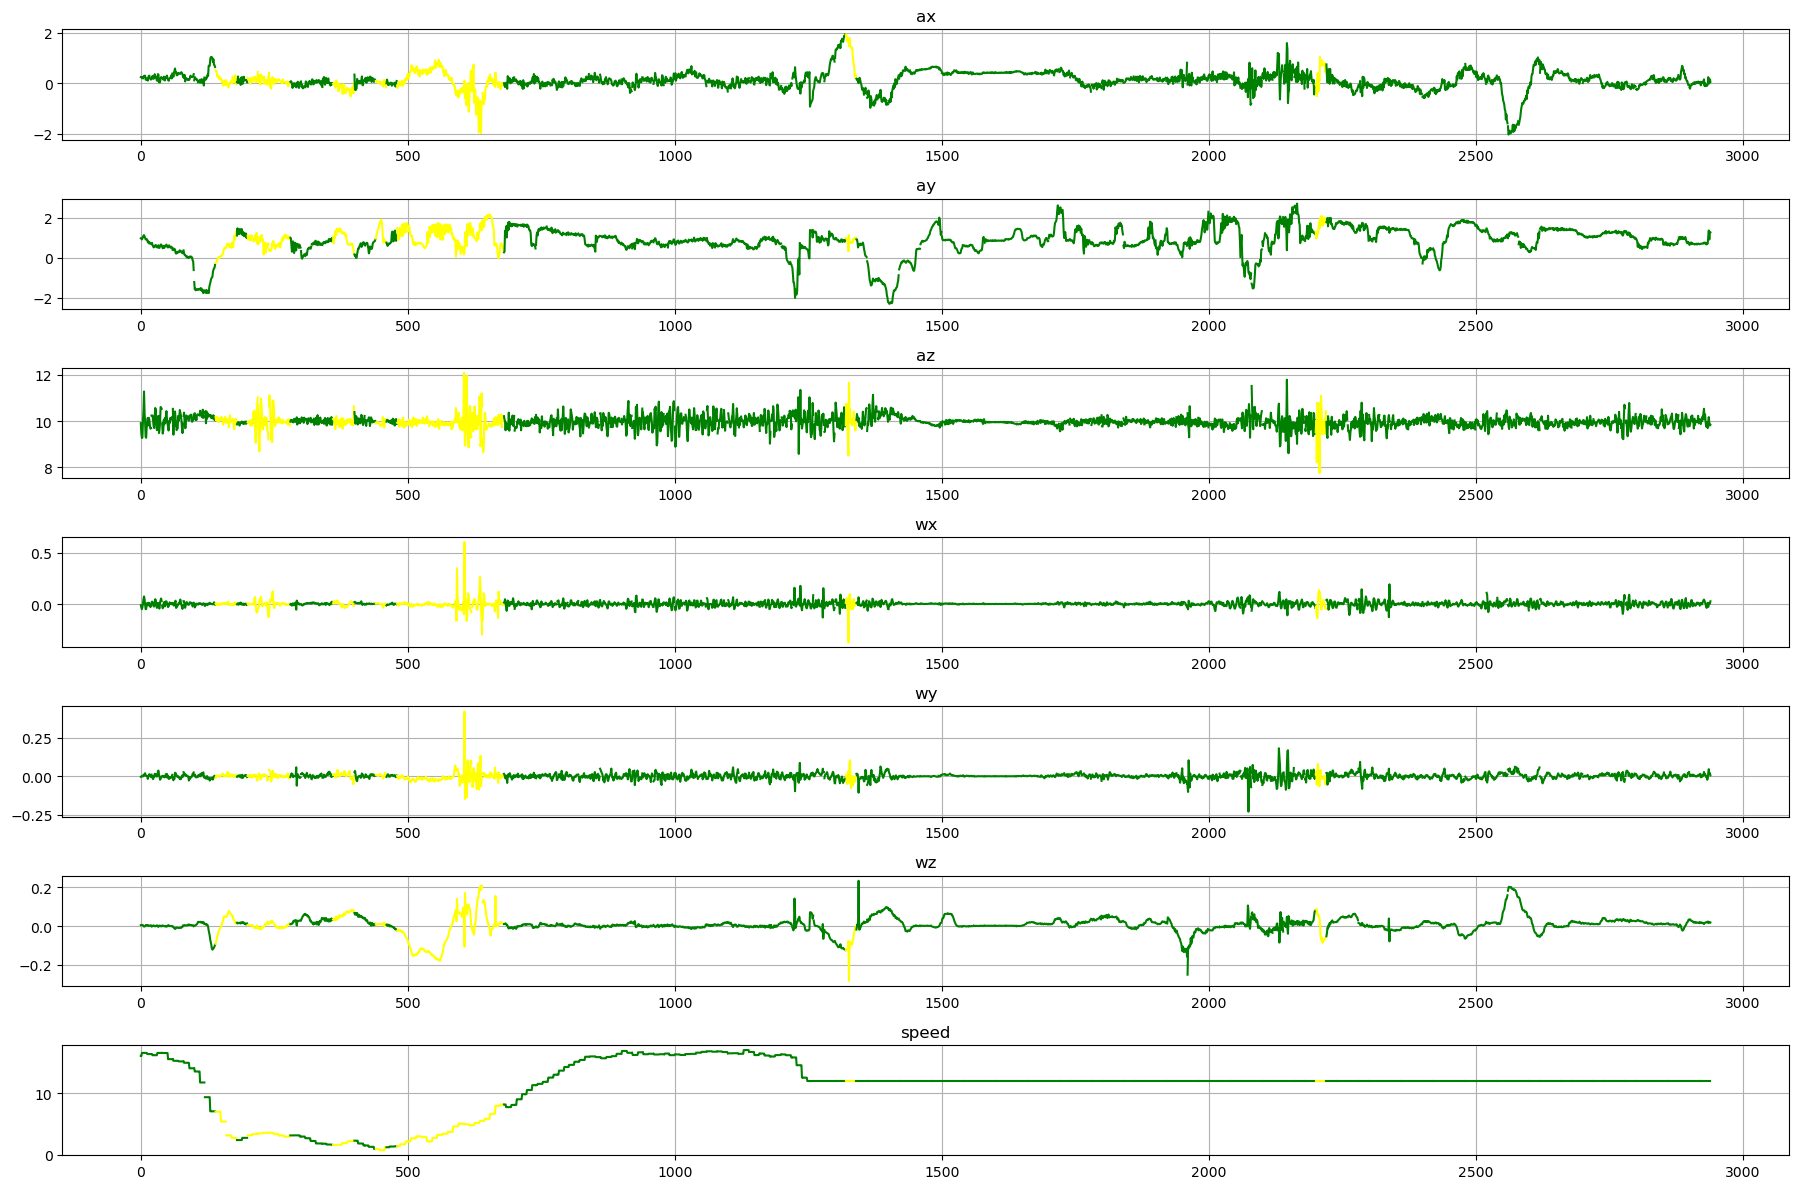

In [44]:
features = ['ax', 'ay', 'az', 'wx', 'wy', 'wz', 'speed']

# color map for classes
color_map = {
    0: 'green',
    1: 'yellow',
    2: 'orange',
    3: 'blue'
}

window_size = 20

# Create x-axis for full dataframe
x_full = np.arange(len(df))

plt.figure(figsize=(18, 12))

for idx, feature in enumerate(features, 1):
    plt.subplot(len(features), 1, idx)
    
    y_values = df[feature].values
    
    # Plot window by window with color
    for w, pred in enumerate(roadQuality):
        start = w * window_size
        end = start + window_size
        
        plt.plot(
            x_full[start:end],
            y_values[start:end],
            color=color_map[pred]
        )
    
    plt.title(feature)
    plt.grid(True)

plt.tight_layout()
plt.show()


6. ploting the coordinates on the map

In [ ]:
# ------------------------------------------------------------
# STEP 1: Expand window predictions to per-row predictions
# ------------------------------------------------------------
window_size = 20

row_preds = np.empty(len(df))
row_preds[:] = np.nan  # initialize

for w, pred in enumerate(roadQuality):
    start = w * window_size
    end = start + window_size
    row_preds[start:end] = pred

# ------------------------------------------------------------
# STEP 2: Plot on Folium map using row-wise predictions
# ------------------------------------------------------------
color_map = {
    0: 'green',
    1: 'yellow',
    2: 'orange',
    3: 'blue'
}

m = folium.Map(
    location=[df['latitude'].mean(), df['longitude'].mean()],
    zoom_start=15
)

for lat, lon, pred in zip(df['latitude'], df['longitude'], row_preds):
    if np.isnan(pred):
        continue

    folium.CircleMarker(
        location=[lat, lon],
        radius=4,
        color='black',        # border
        weight=1,
        fill=True,
        fill_color=color_map[int(pred)],
        fill_opacity=0.9
    ).add_to(m)

m.save("road_quality_map.html")

print("Map saved as road_quality_map.html")


Map saved as road_quality_map.html
